In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rc_file_defaults()
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import csv
import datetime as dt
from dateutil.relativedelta import relativedelta
import warnings
from sklearn.metrics import f1_score, accuracy_score, classification_report
warnings.filterwarnings("ignore")
%load_ext autoreload
from itertools import cycle

In [2]:
# Utils
%autoreload 2
from state_cannabis_policy_date import state_eff_dates, medicalEffDate, limitedMedicalEffDate
import general_utils

In [3]:
analysisDf = pd.read_csv("Jan_v2_final_info_analysis_df.csv")
# analysisDf.head()

In [4]:
analysisDf.shape

(285968, 7)

In [5]:
usPop = pd.read_csv('us_demography.csv')
popDf = usPop.groupby(["StateName", "State"]).agg({'Population':'sum'}).reset_index()
popDf.rename(columns={'StateName': 'state'}, inplace=True)

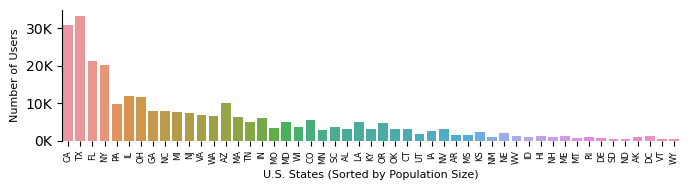

In [6]:
plt.figure(figsize=(7,2))
general_utils.plot_statewise_stats(analysisDf, popDf)

In [7]:
# Handle population to include weed tweets with negative or neutral stance depending on polarity scheme
def get_pop_df(df, treatment_state):
    state_eff_date = state_eff_dates[treatment_state]
    popDf = df[
    (df['stance_pred']==1) & 
    (df['first_juul_date'] < state_eff_date) & 
    ((df['first_weed_date'].isna()) | (df['first_weed_date'] >= state_eff_date))] 
    return popDf
def assign_control(state, treatment_eff, treatment_state='California'):
    recreational_eff = state_eff_dates.get(state, None)
    medical_eff = medicalEffDate.get(state, None)
    limited_medical_eff = limitedMedicalEffDate.get(state, None)
    if state == treatment_state:
          return 0
    if recreational_eff is not None and recreational_eff <= treatment_eff:
          return 4
    if medical_eff is not None and medical_eff <= treatment_eff:
          return 3
    if limited_medical_eff is not None and limited_medical_eff <= treatment_eff:
          return 2
    return 1 # illegal in all forms

def assign_treatment_control(treatment_state, popDf, date_threshold):
    treatment_eff = state_eff_dates[treatment_state]
    popDf['control'] = popDf['state'].apply(lambda x: assign_control(x, treatment_eff, treatment_state))
    return assign_outcome(popDf, date_threshold)

def assign_outcome(popDf, date_threshold):
    popDf['outcome'] = popDf['stance_pred_weed'].fillna(0) * (popDf['first_weed_date']<=date_threshold).astype('int')
    return popDf

def get_treatment_outcome(treatment_state, df):
    popDf = get_pop_df(df, treatment_state)
    treatment_eff_date = state_eff_dates[treatment_state]
    date_obj = dt.datetime.strptime(treatment_eff_date, '%Y-%m-%d')
    allDfs = []
    for month in range(1, 7):
        date_threshold = date_obj + relativedelta(months=month)
        date = date_threshold.strftime('%Y-%m_%d')
        controlDf = assign_treatment_control(treatment_state, popDf, date)
        # outcomeDf = controlDf.groupby('control')['outcome'].describe().reset_index()
        outcomeDf = controlDf.groupby('control').agg({'outcome':['mean', 'std', 'count']}).reset_index()
        outcomeDf['month'] = month
        allDfs.append(outcomeDf)
    resDf = pd.concat(allDfs, ignore_index=False)
    resDf.columns = ['control', 'mean', 'std', 'count', 'month']
    resDf['controlName'] = resDf['control'].replace({0:'T', 1:'C1', 2:'C2', 3:'C3', 4:'C4'})
    ax = sns.lineplot(x='month', y='mean', palette='Set1',
                    hue='controlName', data= resDf)
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Treatment/Control Groups')
    # legend = ax.legend()
    # legend.texts[0].set_text("Treatment/Control Groups")
    legend.texts[0].set_text("T: {} with legalization effective on {}".format(treatment_state, treatment_eff_date))
    legend.texts[4].set_text("$C_4$: States with legalization effective before {}".format(treatment_eff_date))
    legend.texts[3].set_text("$C_3$: States with legal medical marijuana before {}".format(treatment_eff_date))
    legend.texts[2].set_text("$C_2$: States with restricted (low THC) legal medical marijuana before {}".format(treatment_eff_date))
    legend.texts[1].set_text("$C_1$: States with illegal marijuana on {}".format(treatment_eff_date))
    ax.grid(True)
    ax.set_xlabel('Number of months since legalization effective ({}) on {}'.format(treatment_eff_date, treatment_state))
    ax.set_ylabel('Percentage of pro-JUUL users starting pro-marijuana tweets $E(O=1|T)$')
    ax.set_xlim(1,6)
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    return resDf

## California

              California


,control,mean,std,count,month,controlName
0,0,0.069319,0.254072,1659,6,T
1,1,0.050081,0.218288,619,6,C1
2,2,0.052757,0.223592,2521,6,C2
3,3,0.050627,0.219252,6222,6,C3
4,4,0.054953,0.227965,1474,6,C4


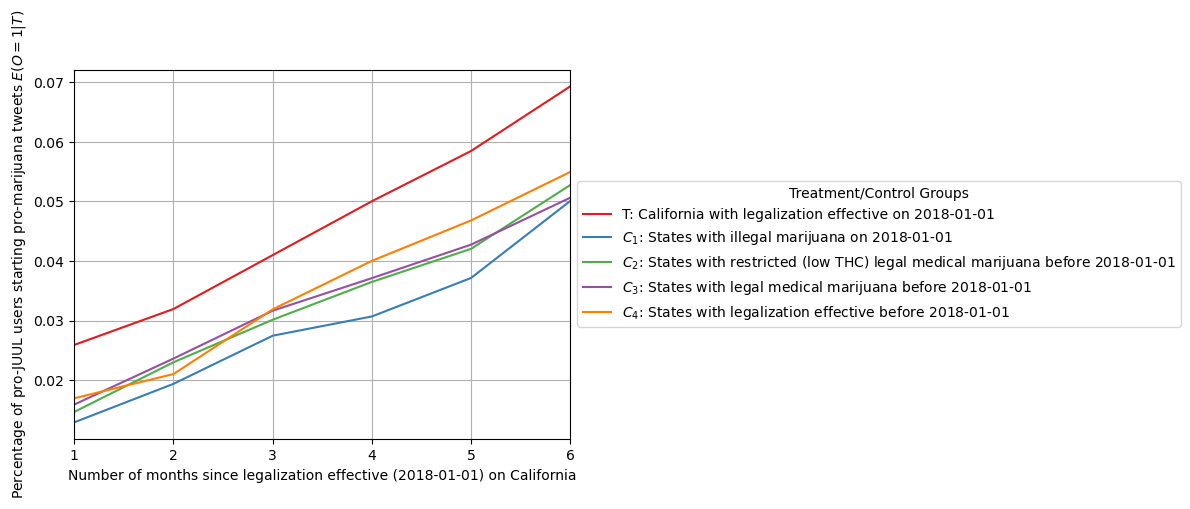

In [8]:
resDf = get_treatment_outcome('California', analysisDf)
print("              California")
resDf[resDf['month']==6]

              Massachusetts


,control,mean,std,count,month,controlName
0,0,0.100000,0.303046,50,6,T
1,1,0.000000,0.000000,49,6,C1
2,2,0.055749,0.229837,287,6,C2
3,3,0.039231,0.194218,1300,6,C3
4,4,0.108280,0.311728,157,6,C4


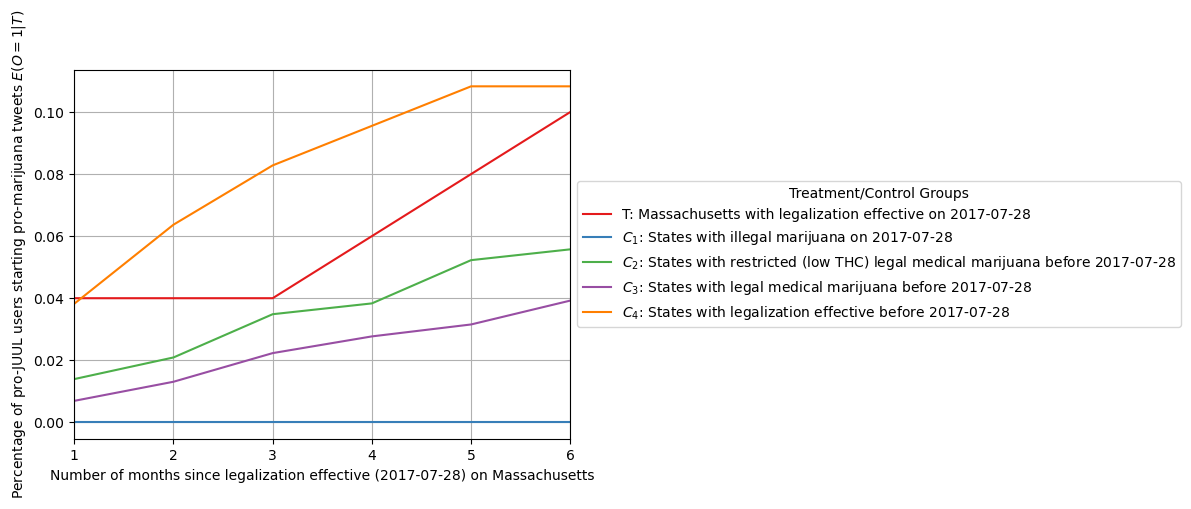

In [9]:
resDf = get_treatment_outcome('Massachusetts', analysisDf)
print("              Massachusetts")
resDf[resDf['month']==6]

              Vermont


,control,mean,std,count,month,controlName
0,0,0.032787,0.179556,61,6,T
1,1,0.042955,0.202815,1746,6,C1
2,2,0.052390,0.222825,9162,6,C2
3,3,0.048050,0.213879,16337,6,C3
4,4,0.053797,0.225632,7584,6,C4


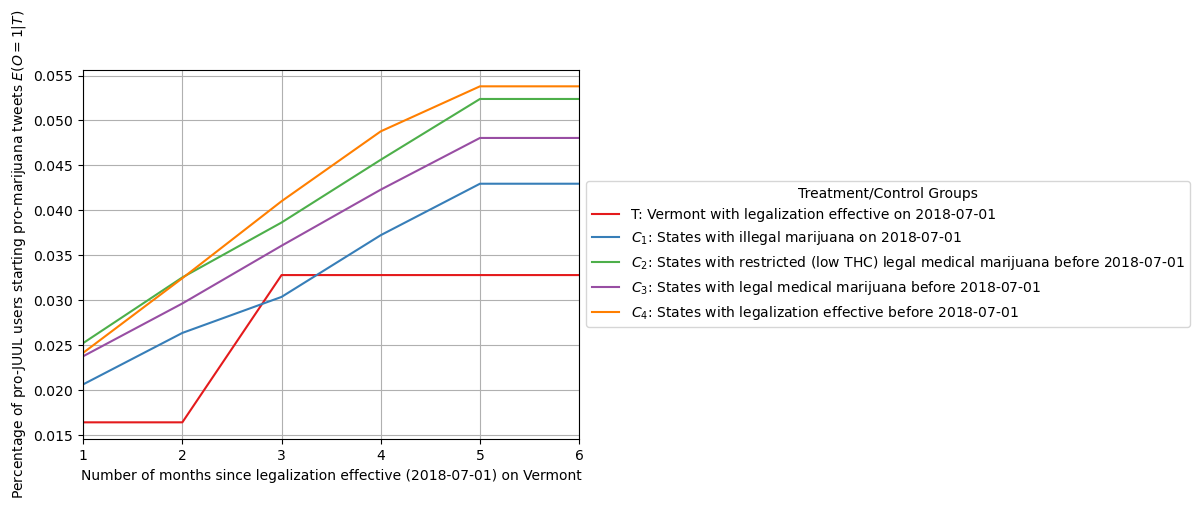

In [10]:
resDf = get_treatment_outcome('Vermont', analysisDf)
print("              Vermont")
resDf[resDf['month']==6]

In [5]:
juul_df = pd.read_csv('analysisJuulStance.csv', lineterminator='\n', index_col='index')
# juul_df.head(3)

In [6]:
weed_df = pd.read_csv('analysisWeedStance.csv', lineterminator='\n', index_col='index')
# weed_df.head(3)

In [13]:
import tensorflow as tf
def get_prob_stance(df):
    probs = df[['anti_prob', 'neutral_prob', 'pro_prob']].values
    preds = tf.random.categorical(tf.math.log(probs), 1).numpy().reshape(-1)
    return pd.Series(preds, index=df.index)

def get_det_stance(df):
    preds = np.argmax(df[['anti_prob', 'neutral_prob', 'pro_prob']].values, axis=1)
    return pd.Series(preds, index=df.index)

def user_stance_pol(treatment_eff_date, base_df, org_juul_df, weed_df, det=False):
    juul_df = org_juul_df[org_juul_df['tweetCreatedAt'] < treatment_eff_date]
    if det:
        predsWeed = get_det_stance(weed_df).to_frame(name='stance_pred_weed')
        predsJuul = get_det_stance(juul_df).to_frame(name='stance_pred')
    else:
        predsWeed = get_prob_stance(weed_df).to_frame(name='stance_pred_weed')
        predsJuul = get_prob_stance(juul_df).to_frame(name='stance_pred')
    jdf = pd.concat([juul_df[['userID', 'tweetCreatedAt']], predsJuul-1], axis=1)
    jdf = (jdf.groupby('userID')['stance_pred'].mean()>0).astype('int').to_frame()
    wdf = pd.concat([weed_df[['userID', 'tweetCreatedAt']], predsWeed-1], axis=1)
    wdf = (wdf.groupby('userID')['stance_pred_weed'].mean()>0).astype('int').to_frame()
    df = base_df.merge(jdf, left_on='userID', right_index=True, how='left').merge(wdf,
                            left_on='userID', right_index=True, how='left')
    return df

In [14]:
base_df = analysisDf.drop(['stance_pred', 'stance_pred_weed'], axis=1)

In [15]:
weed_df['stance_pred'].value_counts(normalize=True)

1    0.82020
2    0.17021
0    0.00959
Name: stance_pred, dtype: float64

In [16]:
preds = get_det_stance(juul_df)-1
preds.value_counts(normalize=True)

 1    0.549323
 0    0.406878
-1    0.043798
dtype: float64

In [17]:
preds = get_det_stance(weed_df)-1
preds.value_counts(normalize=True)

 0    0.82020
 1    0.17021
-1    0.00959
dtype: float64

In [18]:
testdf = user_stance_pol('2018-01-01', base_df, juul_df, weed_df, det=False)
print(testdf['stance_pred'].value_counts(normalize=True))
print(testdf['stance_pred_weed'].value_counts(normalize=True))

1.0    0.548559
0.0    0.451441
Name: stance_pred, dtype: float64
1.0    0.640728
0.0    0.359272
Name: stance_pred_weed, dtype: float64


In [19]:
# testdf = user_stance_pol('2017-07-28', base_df, jdf, weed_df, det=False)
# print(testdf['stance_pred'].value_counts())
# print(testdf['stance_pred_weed'].value_counts(normalize=True))

In [20]:
testdf[(testdf['state']=='Massachusetts') & (testdf['stance_pred']==1) & (
    (testdf['first_weed_date'].isna())|(testdf['first_weed_date']>'2017-07-28'))].shape

(273, 7)

## Constructing Features for Causal Analysis

In [21]:
def glove2dict(glove_filename):
    with open(glove_filename, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONE)
        embed = {line[0]: np.array(list(map(float, line[1:])))
                for line in reader}
    return embed
wvTwitter200 = glove2dict('/AD-HOME/shared/glove_twitter/glove.twitter.27B.200d.txt')

In [206]:
wvTwitter100 = glove2dict('/AD-HOME/shared/glove_twitter/glove.twitter.27B.100d.txt')

In [22]:
wvTwitter25 = glove2dict('/AD-HOME/shared/glove_twitter/glove.twitter.27B.25d.txt')

In [145]:
wvTwitter50 = glove2dict('/AD-HOME/shared/glove_twitter/glove.twitter.27B.50d.txt')

In [189]:
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stopwords=nltk.corpus.stopwords.words('english')
import re
import string
import os
from joblib import load, dump
# stpwords = list(STOPWORDS)
# stpwords.extend(stopwords)

posMapping = {
      "N":'n',
      "V":'v',
      "J":'a',
      "R":'r'
  }

def process_text(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    text = text.lower()
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '',text)

    text = text.replace("'s", "")
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text, preserve_line=True)
    tokens_pos = nltk.pos_tag(tokens)
    tokens_root = []
    for token, pos in tokens_pos:
        try:
            root_word = lemmatizer.lemmatize(token, pos=posMapping.get(pos[0],'n'))
            tokens_root.append(root_word)
        except Exception as e:
            print(e)
            continue
    text = text.replace("'", "")
    for punc in string.punctuation:
        text = text.replace(punc, " ")
    return " ".join(tokens_root)


def process_df(dataset, treatment_eff_date, train=True):
    dataset["tweetText"] = dataset["tweetText"].apply(lambda x: process_text(x))
    return dataset


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec, stopwords, dim):
        self.word2vec = word2vec
        self.stopwords = stopwords
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = dim

    def fit(self, X, y=None):
      #TODO Vec
      return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words.split(" ") if (w in self.word2vec) and (w not in self.stopwords)]
                    or [np.zeros(self.dim)], axis=0)
            # [w for w in words.split(" ") if (w in self.word2vec) and (w in self.vectorizer.get_feature_names())]
            for words in X
        ])



[nltk_data] Downloading package stopwords to /AD-
[nltk_data]     HOME/sadhik9/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /AD-
[nltk_data]     HOME/sadhik9/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to /AD-
[nltk_data]     HOME/sadhik9/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [190]:
def marijuana_policy(state, treatment_eff):
    recreational_eff = state_eff_dates.get(state, None)
    medical_eff = medicalEffDate.get(state, None)
    limited_medical_eff = limitedMedicalEffDate.get(state, None)

    if recreational_eff is not None and recreational_eff <= treatment_eff:
          return 3
    if medical_eff is not None and medical_eff <= treatment_eff:
          return 2
    if limited_medical_eff is not None and limited_medical_eff <= treatment_eff:
          return 1
    return 0 # illegal in all forms

def prepare_matching_df(df, textDf, treatment_state, word2vec=wvTwitter200, word2vecDim=200, textCol='text'):
    if treatment_state == 'Massachusetts':
        word2vec = wvTwitter25
        word2vecDim=25
    elif treatment_state == 'Vermont':
        word2vec = wvTwitter25
        word2vecDim=25
    treatment_eff_date = state_eff_dates[treatment_state]
#     print(treatment_state, treatment_eff_date)
    popState = get_pop_df(df, treatment_state)
    textDf = textDf.merge(popState, on=['userID', 'state'])
#     print(textDf.userID.nunique())
    textDf = textDf[textDf['tweetCreatedAt']<treatment_eff_date]
#     dataset = process_df(textDf, treatment_eff_date)
    dataset = textDf
    wordVec = MeanEmbeddingVectorizer(word2vec=word2vec, stopwords=stopwords, dim=word2vecDim)
    wordVec.fit(dataset[textCol].values)
    tweetFeatures = wordVec.transform(dataset[textCol].values)
    tweetFeaturesDf = pd.DataFrame(data=tweetFeatures)
    statFeaturesDf = dataset.reset_index()[["userID"]].fillna(0)
    allFeaturesDf = statFeaturesDf.merge(tweetFeaturesDf, left_index=True, right_index=True)
    allUserFeaturesDf = allFeaturesDf.groupby('userID').mean().reset_index()
    featureNames = allUserFeaturesDf.columns
    popStateFeatures = popState.merge(allUserFeaturesDf, on='userID', how='left')
    popStateFeatures["policy"] = popStateFeatures["state"].apply(lambda x: marijuana_policy(x, treatment_eff_date))
    popStateFeatures['control'] = popStateFeatures['state'].apply(lambda x: assign_control(x, treatment_eff_date, treatment_state=treatment_state))
    return popStateFeatures, featureNames[1:]

## Matching
### Fully Blocked Matching
- Cosine Similarity

### Propensity Score Matching
- Inverse probability of treatment weighting
- Propensity score matching
#### Propensity Score Models
- Logistic Regression (sklearn)
- Gradient Boosting Machine (lightGBM)

In [22]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, PredefinedSplit
import lightgbm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix, classification_report
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
# from scipy import stats

def construct_dataset(popStateFeatures, control):
    dataset = popStateFeatures[popStateFeatures['control'].isin([0,control])]
    dataset['label'] = ((dataset['control'] == 0)).astype('int')
#     print(dataset['label'].value_counts(normalize=True))
    return dataset

In [23]:
# sensitivity of two propensity score models: Logistic Regression, LightGBM
def propensity_score_model(dataset, featureNames,  model='LR', balanced='balanced'):
    """
    @param dataset: dataframe with all features and a 'label' column
    @param featureNames: 
    """
    matchFeatures = dataset[featureNames]
    matchLabels = dataset['label']
#     trainX, testX, trainY, testY = train_test_split(matchFeatures, matchLabels, test_size=0.10, random_state=3, stratify=matchLabels)
    if model=='LR':
        psModel = LogisticRegression(class_weight=balanced)
    else:
        psModel = lightgbm.LGBMClassifier(class_weight=balanced, max_depth=1)

    psModel.fit(matchFeatures, matchLabels)
#     print(f1_score(matchLabels, psModel.predict(matchFeatures)))
    propScores = psModel.predict_proba(dataset[featureNames])[:,1]
    dataset['propScores'] = propScores
    return dataset

In [24]:

class PSMatching():
    def __init__(self):
        """
        """
        self.nn = NearestNeighbors(n_jobs=-1)

    def fit(self, df, outcome='outcome', treatment='label', prop_scores='propScores'):
        """
        df: dataframe containing the columns
        outcome: Name of outcome column
        treatment: Name of treatment column
        prop_scores: Name of propensity score matching column
        """
        self.treatment = treatment
        self.outcome = outcome
        self.prop_scores = prop_scores
        self.treatment_df = df[df[treatment]==1].reset_index()
        self.control_df = df[df[treatment]!=1].reset_index()
        self.nn.fit(self.control_df[[prop_scores]].values)


    def match(self, k=1, radius=1, with_replacement=True):
        lookup = self.nn.radius_neighbors_graph(self.treatment_df[[self.prop_scores]].values,
                                                radius=radius, mode='distance')
        matched = []
        match_results = {}
        for i in range(self.treatment_df.shape[0]):
            distance = lookup[i].data
            matches = lookup[i].indices
            sorted_ind = np.argsort(distance)
            distance = distance[sorted_ind]
            matches = matches[sorted_ind]
            pairs = list(zip(matches, distance))
            for pair in pairs:
                if with_replacement:
                    match_results[i] = pair
                    break
                else:
                    if pair[0] not in matched:
                        match_results[i] = pair
                        matched.append(pair[0])
                        break
        match_nr = pd.DataFrame.from_dict(match_results, orient='index', columns=['match', 'distance'])
        matched = self.control_df.iloc[match_nr['match'].values]
        # return matched
        return pd.concat([matched, self.treatment_df])
    # return match_nr 


In [25]:
class FBMatching():
    def __init__(self, metric='cosine'):
        """
        """
        self.nn = NearestNeighbors(n_jobs=-1, metric=metric)

    def fit(self, df, features, treatment='label'):
        """
        df: dataframe containing the columns
        treatment: Name of treatment column
        """
        self.treatment = treatment
        self.features = features
        self.treatment_df = df[df[treatment]==1].reset_index()
        self.control_df = df[df[treatment]!=1].reset_index()
        self.nn.fit(self.control_df[self.features].values)


    def match(self, k=1, radius=1, with_replacement=True):
        lookup = self.nn.radius_neighbors_graph(self.treatment_df[self.features].values,
                                                radius=radius, mode='distance')
        matched = []
        match_results = {}
        for i in range(self.treatment_df.shape[0]):
            distance = lookup[i].data
            matches = lookup[i].indices
            sorted_ind = np.argsort(distance)
            distance = distance[sorted_ind]
            matches = matches[sorted_ind]
            pairs = list(zip(matches, distance))
            for pair in pairs:
                if with_replacement:
                    match_results[i] = pair
                    break
                else:
                    if pair[0] not in matched:
                        match_results[i] = pair
                        matched.append(pair[0])
                        break
        match_nr = pd.DataFrame.from_dict(match_results, orient='index', columns=['match', 'distance'])
        matched = self.control_df.iloc[match_nr['match'].values]
        # return matched
        return pd.concat([matched, self.treatment_df])

## Check covariate balance before and after Matching
- Check balance for Inverse Probability of propensity score weighting method
- Check balance for Fully-blocked/propensity score matching

In [26]:
def getFeatureStat(df, features_cols, weight_col=None):
    if weight_col is None:
        weight_col = 'sd_weight'
        df[weight_col] = 1.0
    count = df.shape[0]
    repeat = len(features_cols)
    weighted = np.repeat(df[weight_col].values.reshape(-1,1), repeats=repeat, axis=1) * df[features_cols].values
    mean = weighted.mean(axis=0)
    std = weighted.std(axis=0)
    return count, mean, std

def calculate_smd(mean1, mean2, std1, std2):
    num = np.abs(mean1 - mean2)
    deno = np.sqrt((std1**2 + std2**2) / 2)
    return num/deno


def access_iptw_balance(dataset, featureNames):
    att_weights = dataset['label'] + (1 - dataset['label']) * (dataset['propScores']/(1-dataset['propScores']))
    ate_weights = dataset['label']/dataset['propScores'].clip(0.05,1) + (
        (1 - dataset['label'])/(1-dataset['propScores'].clip(0, 0.95)))
    dataset['attWeight'] = att_weights
    dataset['ateWeight'] = ate_weights
    treatment_df = dataset[dataset['label']==1]
    control_df = dataset[dataset['label']==0]
    rawTCount, rawTMean, rawTStd = getFeatureStat(treatment_df, featureNames)
    rawCCount, rawCMean, rawCStd = getFeatureStat(control_df, featureNames)
    rawSmd = calculate_smd(rawTMean, rawCMean, rawTStd, rawCStd)
    tCount, tMean, tStd = getFeatureStat(treatment_df, featureNames, weight_col='ateWeight')
    cCount, cMean, cStd = getFeatureStat(control_df, featureNames, weight_col='ateWeight')
    smd = calculate_smd(tMean, cMean, tStd, cStd)
    sortedRawSmd = -1 * np.sort(-1 * rawSmd)
    sortedIndices = np.argsort(-1* rawSmd)
    sortedFeatures =  np.array(featureNames)[sortedIndices]
    otherFeatures = np.array(featureNames)[np.where(smd>=0.1)]
    sortedSmd = smd[sortedIndices]
    return rawSmd, smd

def access_iptw_matching(dataset, allFeaturesNames):
    rawSmd, smd = access_iptw_balance(dataset, allFeaturesNames)
    smdData = np.vstack([smd, rawSmd]).transpose()
    smdDf = pd.DataFrame(smdData)
    smdDf = smdDf.melt(value_name='smd', var_name='raw')
    return smdDf


def access_ps_balance(psMatchingObj, matchDf, allFeaturesNames):
    treatment_df = psMatchingObj.treatment_df
    raw_control_df = psMatchingObj.control_df
    control_df = matchDf[matchDf['label']==0]
    rawTCount, rawTMean, rawTStd = getFeatureStat(treatment_df, allFeaturesNames)
    rawCCount, rawCMean, rawCStd = getFeatureStat(raw_control_df, allFeaturesNames)
    rawSmd = calculate_smd(rawTMean, rawCMean, rawTStd, rawCStd)
    tCount, tMean, tStd = rawTCount, rawTMean, rawTStd
    cCount, cMean, cStd = getFeatureStat(control_df, allFeaturesNames)
    smd = calculate_smd(tMean, cMean, tStd, cStd)
    return rawSmd, smd

def access_ps_matching(psMatchingObj, matchDf, allFeaturesNames):
    rawSmd, smd = access_ps_balance(psMatchingObj, matchDf, allFeaturesNames)
    smdData = np.vstack([smd, rawSmd]).transpose()
    smdDf = pd.DataFrame(smdData)
    smdDf = smdDf.melt(value_name='smd', var_name='raw')
    return smdDf

def plot_covariate_balance(accessDf, fontsize=16, labelsize=16, legendsize=16):
    accessDf = accessDf[accessDf['bootstrap']==0]
    plt.subplot(111)
    ax = sns.boxplot(x='control', y='smd', data=accessDf, palette='Set1', hue='raw', hue_order=[1,0])#, split=True)
    ax.hlines(0.1,-1,4, linestyles='--')
    plt.xlabel("Control Groups", fontsize=fontsize)
    plt.ylabel("ASMD", fontsize=fontsize)
    plt.xticks(ticks=[0,1,2,3], labels=['$C_1$', '$C_2$', '$C_3$', '$C_4$'])
    legend = ax.legend(title='Covariates', fontsize=legendsize, title_fontsize=legendsize, loc='upper right')
    ax.tick_params(axis = 'both', which = 'major', labelsize = labelsize)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = labelsize)
    legend.texts[0].set_text('Unmatched')
    legend.texts[1].set_text('Matched')
    plt.tight_layout()
    # plt.show()

## Calculate ATE from matched dataset
- ATE for IPTW method
- ATE for PS-Matching and FB-Matching

In [27]:
def get_estimation_iptw(dataset, treatment_state):
    treatment_eff_date = state_eff_dates[treatment_state]
    date_obj = dt.datetime.strptime(treatment_eff_date, '%Y-%m-%d')
    allDfs = []
    for month in range(1, 7):
        date_threshold = date_obj + relativedelta(months=month)
        date = date_threshold.strftime('%Y-%m-%d')
        outDf = assign_outcome(dataset, date)
        outDf['weightedOutcome'] = outDf['outcome'] * outDf['attWeight']
        outDf['weightedAte'] = outDf['outcome'] * outDf['ateWeight']
        unweighted = outDf.groupby(['policy','label'])['outcome'].mean()
        deno = outDf.groupby(['policy','label'])['attWeight'].describe()
        deno_ate = outDf.groupby(['policy','label'])['ateWeight'].describe()
        num = outDf.groupby(['policy','label'])['weightedOutcome'].describe()
        num_ate = outDf.groupby(['policy','label'])['weightedAte'].describe()
        res = num[['count']]
        res['value'] = num['mean']/deno['mean']
        res['month'] = month
        res['estimation'] = 'ATT'
        allDfs.append(res)
        res = num[['count']]
        res['value'] = unweighted
        res['month'] = month
        res['estimation'] = 'Expectation'
        allDfs.append(res)
        res = num[['count']]
        res['value'] = num_ate['mean']/deno_ate['mean'] # normalized version
        res['month'] = month
        res['estimation'] = 'ATE'
        allDfs.append(res)
    finalDf = pd.concat(allDfs)
    finalDf = finalDf.reset_index()
    return finalDf


def get_estimation_ps(dataset, treatment_state):
    treatment_eff_date = state_eff_dates[treatment_state]
    date_obj = dt.datetime.strptime(treatment_eff_date, '%Y-%m-%d')
    allDfs = []
    for month in range(1, 7):
        date_threshold = date_obj + relativedelta(months=month)
        date = date_threshold.strftime('%Y-%m-%d')
        outDf = assign_outcome(dataset, date)
        unweighted = outDf.groupby(['policy','label'])['outcome'].mean()
        num = outDf.groupby(['policy','label'])['outcome'].describe()
        res = num[['count']]
        res['value'] = unweighted
        res['month'] = month
        res['estimation'] = 'ATE'
        allDfs.append(res)
    finalDf = pd.concat(allDfs)
    finalDf = finalDf.reset_index()
    return finalDf


    
def get_effect(df):
    val = df[df['label']==1]['value'].values[0]
    df['effect'] = val - df['value']
    return df


In [28]:
# plot effects
def get_conf_int(effectsDf):
    stderrEff = effectsDf.groupby(['month', 'estimation', 'policy', 'label', 'control'])['effect'].describe().drop('count', axis=1).reset_index()
    orgEffDf = effectsDf[effectsDf['bootstrap']==0].drop('control', axis=1)
    confEffDf = stderrEff.merge(orgEffDf, on=['month', 'estimation', 'policy', 'label'], how='left')
    confEffDf['effect'] = confEffDf['mean']
    confEffDf['stderr'] = confEffDf['std']/np.sqrt(200)
    confEffDf['confL'] = confEffDf['effect'] - 1.96*confEffDf['stderr']
    confEffDf['confH'] = confEffDf['effect'] + 1.96*confEffDf['stderr']
    return confEffDf

def plot_effects(effectsDf, useLegend=True, ylim=(-0.01, 0.04), fontsize=18, labelsize=18, legendsize=18):
    cmap = plt.get_cmap("Set1")
    confEffDf = get_conf_int(effectsDf)
    if useLegend:
        legArg = 'brief'
    else:
        legArg = False
    ax1 = sns.lineplot(x='month', y='effect', data=confEffDf[confEffDf['estimation'].isin(['ATE'])], hue='control', palette='Set1', ci=None, legend=legArg)
    for ctrl in range(1, 5):
        ctrlDf = confEffDf[(confEffDf['control']==ctrl) & (confEffDf['estimation'].isin(['ATE']))]
        plt.fill_between(ctrlDf['month'], ctrlDf['confL'], ctrlDf['confH'], alpha=0.1, color=cmap(ctrl-1))
    plt.xlabel("Number of months since\ncannabis legalization".format(state_eff_dates[treatment_state]), fontsize=fontsize)
    plt.ylabel("ATE", fontsize=fontsize)
    # ax.grid()
    # ax1.grid()
    ax1.tick_params(axis = 'both', which = 'major', labelsize = labelsize)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize = labelsize)

    if useLegend:
        legend = ax1.legend(fontsize=legendsize, title_fontsize=legendsize, title="Control Groups")#loc='center left', bbox_to_anchor=(1, 0.5))
      # legend.texts[0].set_text("Control Groups")
      # legend.texts[1].set_text("{} (Treatment)".format(treatment_state))
        legend.texts[3].set_text("Recreational ($C_4$)")
        legend.texts[2].set_text("Medical ($C_3$)")
        legend.texts[1].set_text("Limited-THC Medical ($C_2$)")
        legend.texts[0].set_text("Illegal ($C_1$)")
    ax1.hlines(0, 1, 6, linestyles='--')
    plt.xlim(1,6)
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
#     plt.ylim(-0.06, 0.1)

In [29]:
def get_experiment_dataset(treatment_state, base_df, juul_df, weed_df, num_bootstrap=1):
    treatment_eff_date = state_eff_dates[treatment_state]
    if num_bootstrap == 1:
        analysisDf = user_stance_pol(treatment_eff_date, base_df, juul_df, weed_df, det=True)
    else:
        analysisDf = user_stance_pol(treatment_eff_date, base_df, juul_df, weed_df, det=False)
    popStateFeatures, featureNames = prepare_matching_df(analysisDf, juul_df, treatment_state)
    return popStateFeatures, featureNames

def print_info(treatment_state):
    treatment_eff_date = state_eff_dates[treatment_state]
    print(treatment_state, treatment_eff_date)

In [30]:
def run_iptw_experiment(treatment_state, base_df, juul_df, weed_df, model='LR', num_bootstrap=1, useLegend=True, ex_suffix=''):
    print_info(treatment_state)
    combined = []
    match_stats = []
    effectsDf = []
    for sim in tqdm(range(num_bootstrap)):
        popStateFeatures, featureNames = get_experiment_dataset(treatment_state, base_df, juul_df, weed_df, sim+1)
        for control in range(1,5):
            dataset = construct_dataset(popStateFeatures, control)
            sampledDf = dataset
            sampledDf = propensity_score_model(sampledDf, featureNames, model=model, balanced='balanced')
            accessDf = access_iptw_matching(sampledDf, featureNames)
            accessDf['control'] = control
            accessDf['bootstrap'] = sim
            match_stats.append(accessDf)
            resultDf = get_estimation_iptw(sampledDf, treatment_state)
            resultDf['control'] = control
            resultDf['control'] = (1 - resultDf['label']) * resultDf['control']
            resultDf['bootstrap'] = sim
            resultDf['experiment'] = control
            combined.append(resultDf)
            effectDf = resultDf.groupby(['month', 'estimation']).apply(get_effect).reset_index()
            effectDf = effectDf[effectDf['label']==0]
        #     # print(effectDf)
            effectsDf.append(effectDf)

    combinedDf = pd.concat(combined)
    effectsDf = pd.concat(effectsDf)
    accessDf = pd.concat(match_stats)
    file_prefix = f'{treatment_state}_{model}_iptw{ex_suffix}_{num_bootstrap}'
    accessDf.to_csv(f'{file_prefix}_balance_df.csv')
    effectsDf.to_csv(f'{file_prefix}_effect_df.csv')
    plot_covariate_balance(accessDf)
    plt.savefig(f'{treatment_state}_{model}_iptw_balance{ex_suffix}_{num_bootstrap}.pdf')
    plt.show()
    plot_effects(effectsDf, useLegend=useLegend)
    plt.tight_layout()
    plt.savefig(f'{treatment_state}_{model}_iptw_effect{ex_suffix}_{num_bootstrap}.pdf')
    plt.show()
    
    return effectsDf, accessDf, combinedDf

In [31]:
def run_fb_experiment(treatment_state, base_df, juul_df, weed_df, metric='cosine', num_bootstrap=1, useLegend=True, ex_suffix=''):
    print_info(treatment_state)
    combined = []
    match_stats = []
    effectsDf = []
    for sim in tqdm(range(num_bootstrap)):
        popStateFeatures, featureNames = get_experiment_dataset(treatment_state, base_df, juul_df, weed_df, sim+1)
        for control in range(1,5):
            dataset = construct_dataset(popStateFeatures, control)
            sampledDf = dataset
            fbMatching = FBMatching(metric=metric)
            fbMatching.fit(sampledDf, features=featureNames, treatment='label')
            sampledDf = fbMatching.match(with_replacement=True)
            accessDf = access_ps_matching(fbMatching, sampledDf, featureNames)
            accessDf['control'] = control
            accessDf['bootstrap'] = sim
            match_stats.append(accessDf)
            resultDf = get_estimation_ps(sampledDf, treatment_state)
            resultDf['control'] = control
            resultDf['control'] = (1 - resultDf['label']) * resultDf['control']
            resultDf['bootstrap'] = sim
            resultDf['experiment'] = control
            combined.append(resultDf)
            effectDf = resultDf.groupby(['month', 'estimation']).apply(get_effect).reset_index()
            effectDf = effectDf[effectDf['label']==0]
            effectsDf.append(effectDf)

    combinedDf = pd.concat(combined)
    effectsDf = pd.concat(effectsDf)
    accessDf = pd.concat(match_stats)
    file_prefix = f'{treatment_state}_{metric}_fb{ex_suffix}_{num_bootstrap}'
    accessDf.to_csv(f'{file_prefix}_balance_df.csv')
    effectsDf.to_csv(f'{file_prefix}_effect_df.csv')

    plot_covariate_balance(accessDf)
    plt.savefig(f'{treatment_state}_{metric}_fb_balance{ex_suffix}_{num_bootstrap}.pdf')
    plt.show()
    plot_effects(effectsDf, useLegend=useLegend)
    plt.tight_layout()
    plt.savefig(f'{treatment_state}_{metric}_fb_effect{ex_suffix}_{num_bootstrap}.pdf')
    plt.show()
    return effectsDf, accessDf, combinedDf

In [32]:
def run_ps_experiment(treatment_state, base_df, juul_df, weed_df, model='LR', num_bootstrap=1, useLegend=True, ex_suffix=''):
    print_info(treatment_state)
    combined = []
    match_stats = []
    effectsDf = []
    for sim in tqdm(range(num_bootstrap)):
        popStateFeatures, featureNames = get_experiment_dataset(treatment_state, base_df, juul_df, weed_df, sim+1)
        for control in range(1,5):
            dataset = construct_dataset(popStateFeatures, control)
            sampledDf = dataset
            sampledDf = propensity_score_model(sampledDf, featureNames, model=model, balanced='balanced')
            psMatching = PSMatching()
            psMatching.fit(sampledDf, outcome='stance_pred_weed', treatment='label', prop_scores='propScores')
            sampledDf = psMatching.match(with_replacement=True)
            accessDf = access_ps_matching(psMatching, sampledDf, featureNames)
            accessDf['control'] = control
            accessDf['bootstrap'] = sim
            match_stats.append(accessDf)
            resultDf = get_estimation_ps(sampledDf, treatment_state)
            resultDf['control'] = control
            resultDf['control'] = (1 - resultDf['label']) * resultDf['control']
            resultDf['bootstrap'] = sim
            resultDf['experiment'] = control
            combined.append(resultDf)
            effectDf = resultDf.groupby(['month', 'estimation']).apply(get_effect).reset_index()
            effectDf = effectDf[effectDf['label']==0]
            effectsDf.append(effectDf)

    combinedDf = pd.concat(combined)
    effectsDf = pd.concat(effectsDf)
    accessDf = pd.concat(match_stats)
    file_prefix = f'{treatment_state}_{model}_ps{ex_suffix}_{num_bootstrap}'
    accessDf.to_csv(f'{file_prefix}_balance_df.csv')
    effectsDf.to_csv(f'{file_prefix}_effect_df.csv')

    plot_covariate_balance(accessDf)
    plt.savefig(f'{treatment_state}_{model}_ps_balance{ex_suffix}_{num_bootstrap}.pdf')
    plt.show()
    plot_effects(effectsDf, useLegend=useLegend)
#     plt.tight_layout()
    plt.savefig(f'{treatment_state}_{model}_ps_effect{ex_suffix}_{num_bootstrap}.pdf')
    plt.show()
    return effectsDf, accessDf, combinedDf

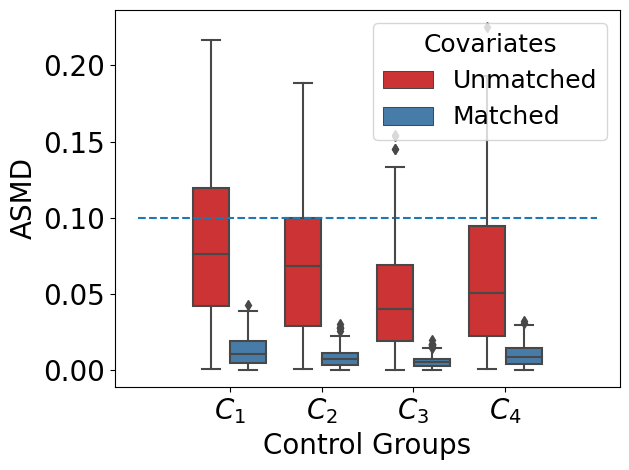

In [33]:
treatment_state='California'
useLegend=True
ex_suffix = '_rt_vis'
method = 'iptw'
model='LR'
num_bootstrap=200
file_prefix = f'{treatment_state}_{model}_{method}{ex_suffix}_{num_bootstrap}'
balanceDf = pd.read_csv(f'{file_prefix}_balance_df.csv')
# plot_effects(effectDf, useLegend=useLegend, ylim=(-0.01, 0.04), fontsize=20, labelsize=20, legendsize=15)
plot_covariate_balance(balanceDf, fontsize=20, labelsize=20, legendsize=18)
plt.tight_layout()
plt.savefig(f'{treatment_state}_{model}_{method}_balance{ex_suffix}_{num_bootstrap}.pdf')


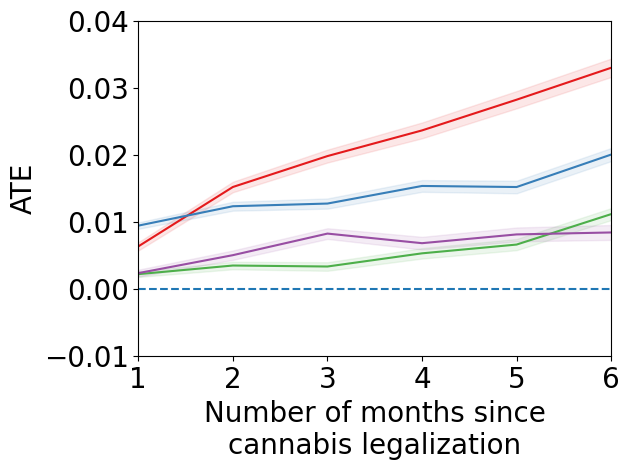

In [36]:
treatment_state='California'
useLegend=False
ex_suffix = '_rt_vis'
method = 'iptw'
model='LR'
num_bootstrap=200
file_prefix = f'{treatment_state}_{model}_{method}{ex_suffix}_{num_bootstrap}'
effectDf = pd.read_csv(f'{file_prefix}_effect_df.csv')
plot_effects(effectDf, useLegend=useLegend, ylim=(-0.01, 0.04), fontsize=20, labelsize=20, legendsize=16)
plt.tight_layout()
plt.savefig(f'{treatment_state}_{model}_{method}_effect{ex_suffix}_{num_bootstrap}.png')


  0%|          | 0/200 [00:00<?, ?it/s]

Vermont 2018-07-01


100%|██████████| 200/200 [37:31<00:00, 11.26s/it]


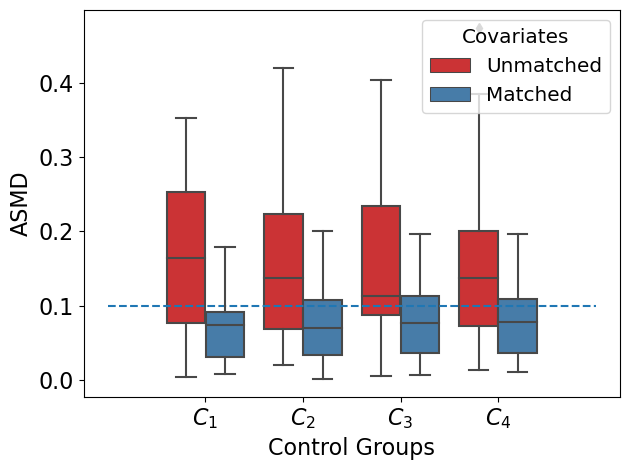

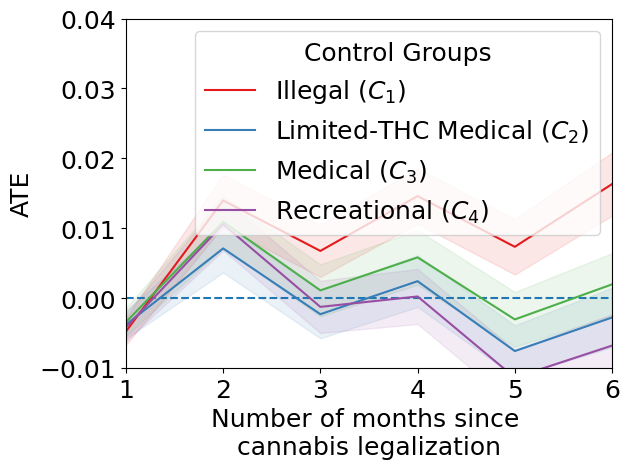

In [225]:
experiment_suffix='_rt_vis'
treatment_state = 'Vermont'
effectsDf, accessDf, combinedDf = run_iptw_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='LR',
                                                      num_bootstrap=200,
                                                      useLegend=True,
                                                      ex_suffix=experiment_suffix
                                                     )

  0%|          | 0/200 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 200/200 [18:10<00:00,  5.45s/it]


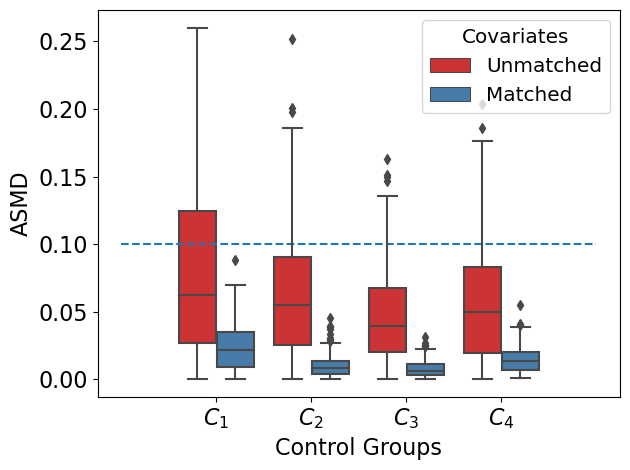

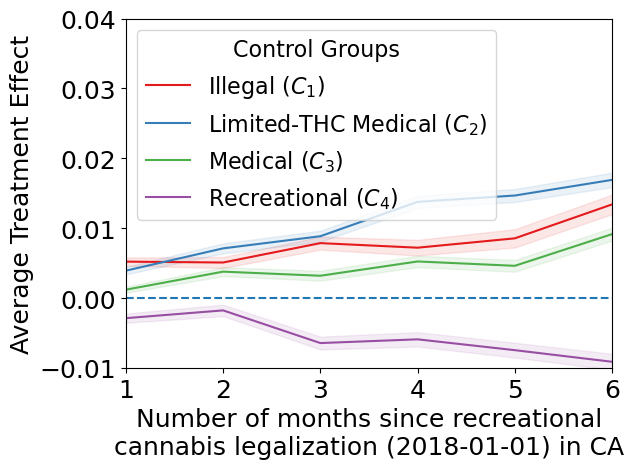

In [160]:
experiment_suffix='_rt_vis'
treatment_state = 'Massachusetts'
effectsDf, accessDf, combinedDf = run_iptw_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='LR',
                                                      num_bootstrap=200,
                                                      useLegend=True,
                                                      ex_suffix=experiment_suffix
                                                     )


  0%|          | 0/200 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 200/200 [25:59<00:00,  7.80s/it]


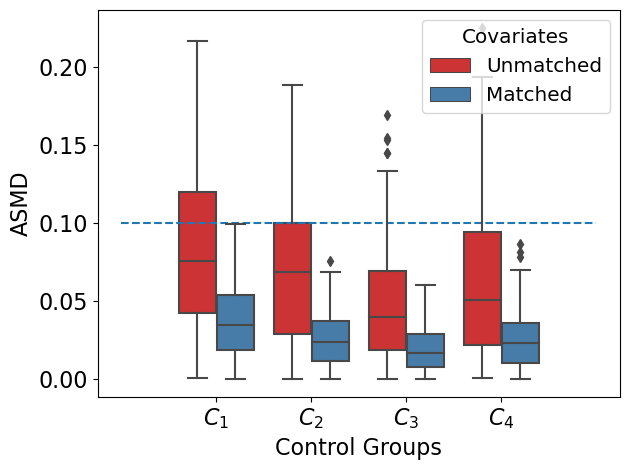

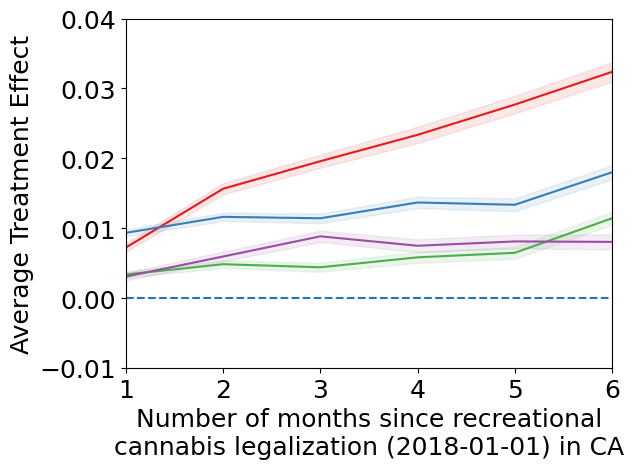

In [117]:
experiment_suffix='_rt_vis'
treatment_state = 'California'
effectsDf, accessDf, combinedDf = run_iptw_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='GBM',
                                                      num_bootstrap=200,
                                                      useLegend=False,
                                                      ex_suffix=experiment_suffix
                                                     )


  0%|          | 0/200 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 200/200 [52:41<00:00, 15.81s/it]


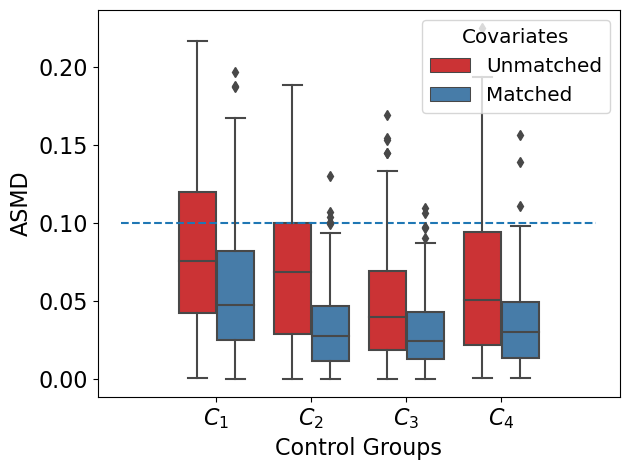

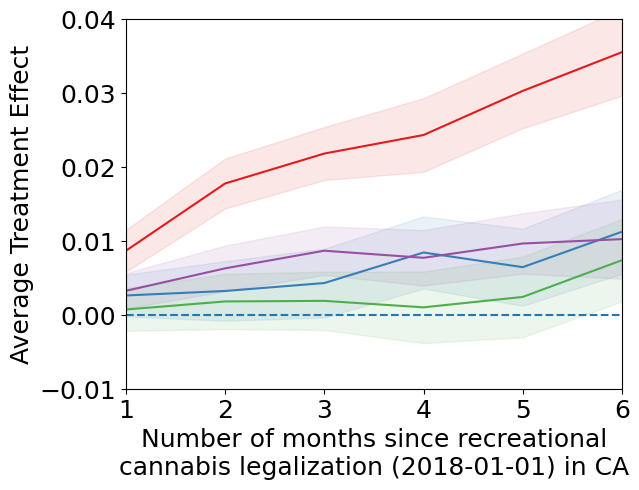

In [119]:
experiment_suffix='_rt_vis'
treatment_state = 'California'
effectsDf, accessDf, combinedDf = run_ps_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='LR',
                                                      num_bootstrap=200,
                                                      useLegend=False,
                                                      ex_suffix=experiment_suffix
                                                     )


  0%|          | 0/200 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 200/200 [51:36<00:00, 15.48s/it]


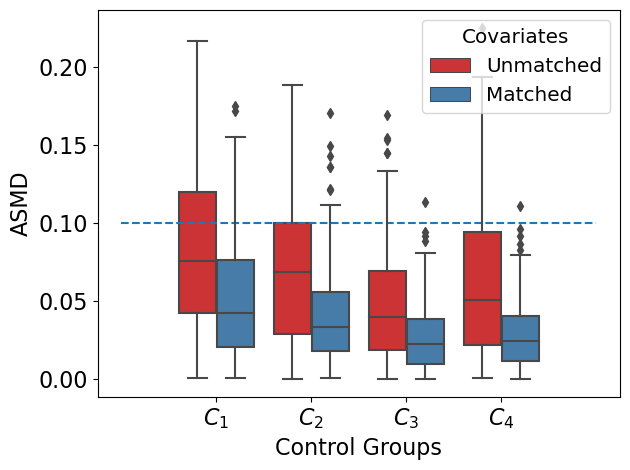

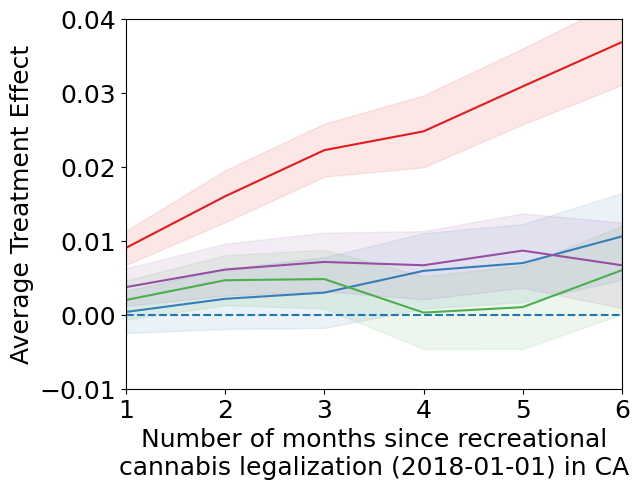

In [120]:
experiment_suffix='_rt_vis'
treatment_state = 'California'
effectsDf, accessDf, combinedDf = run_ps_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='GBM',
                                                      num_bootstrap=200,
                                                      useLegend=False,
                                                      ex_suffix=experiment_suffix
                                                     )

  0%|          | 0/200 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 200/200 [54:27<00:00, 16.34s/it]


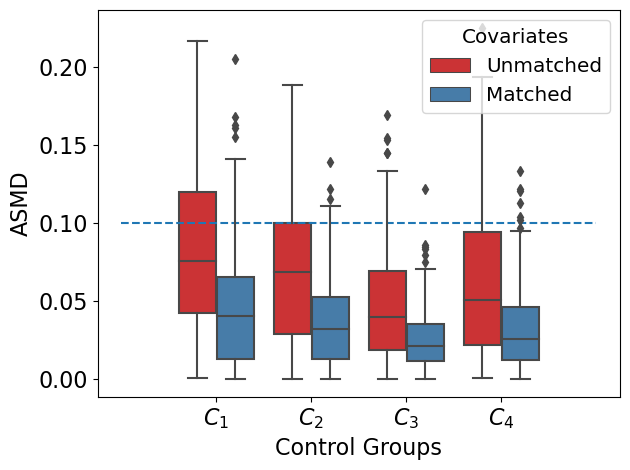

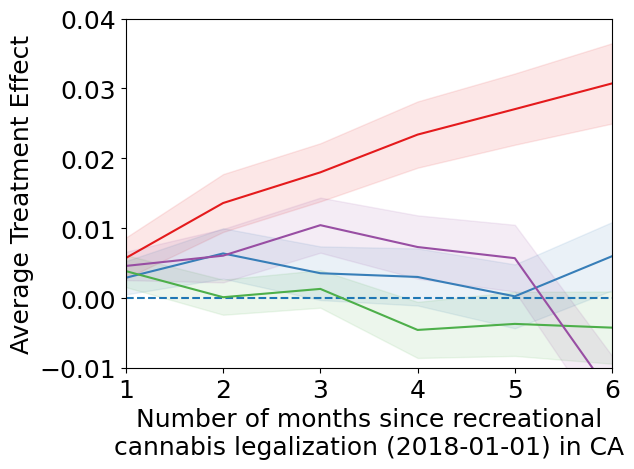

In [121]:
experiment_suffix='_rt_vis'
treatment_state = 'California'
effectsDf, accessDf, combinedDf = run_fb_experiment(treatment_state, base_df, juul_df, weed_df,
                                                    metric='cosine',
                                                    num_bootstrap=200,
                                                    useLegend=False,
                                                    ex_suffix=experiment_suffix
                                                     )

In [213]:
experiment_suffix='_tweet_vis'

  0%|          | 0/2 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 2/2 [00:11<00:00,  5.57s/it]


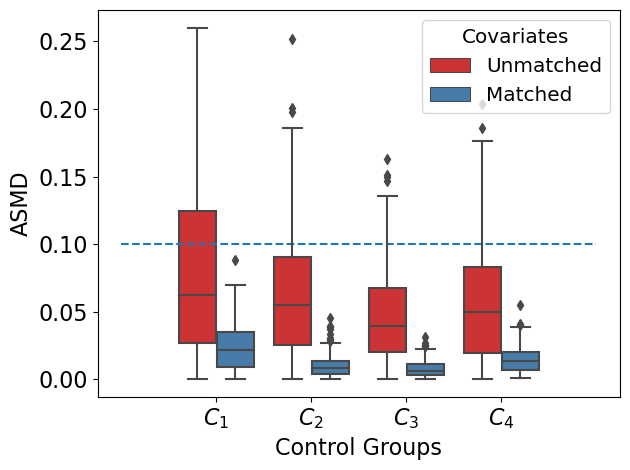

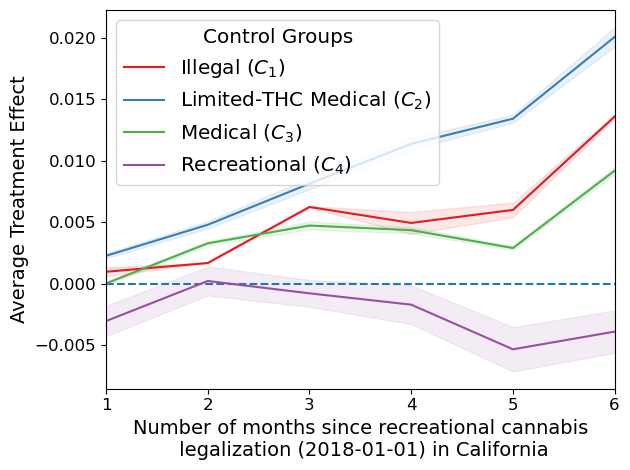

  0%|          | 0/2 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 2/2 [00:11<00:00,  5.75s/it]


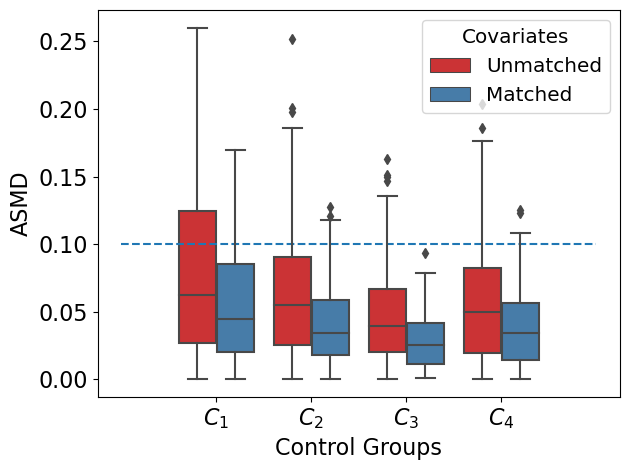

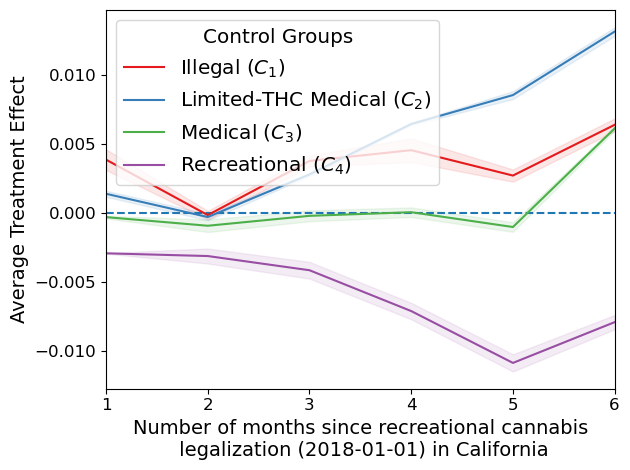

  0%|          | 0/2 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 2/2 [00:13<00:00,  6.93s/it]


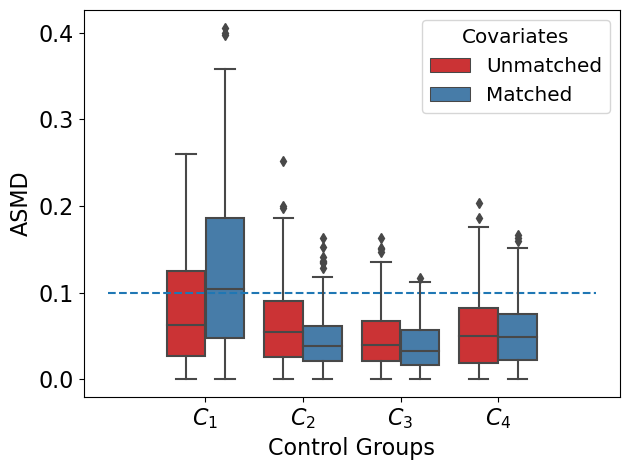

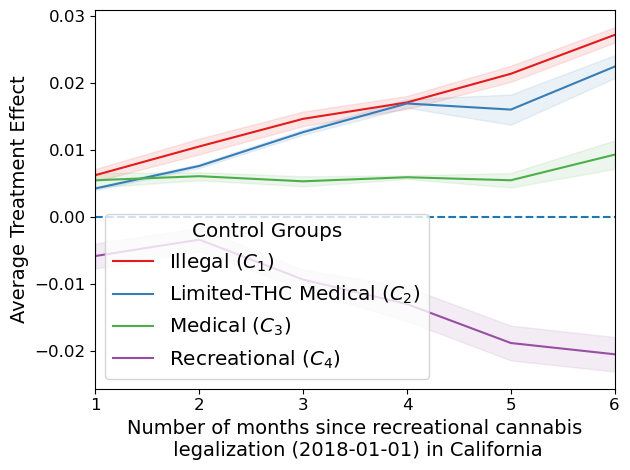

  0%|          | 0/2 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 2/2 [00:14<00:00,  7.42s/it]


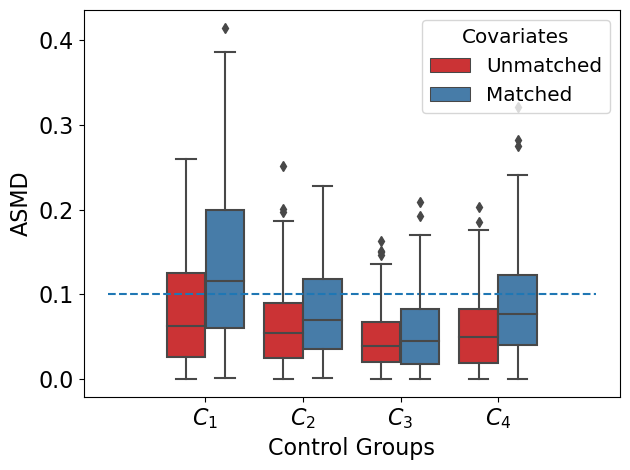

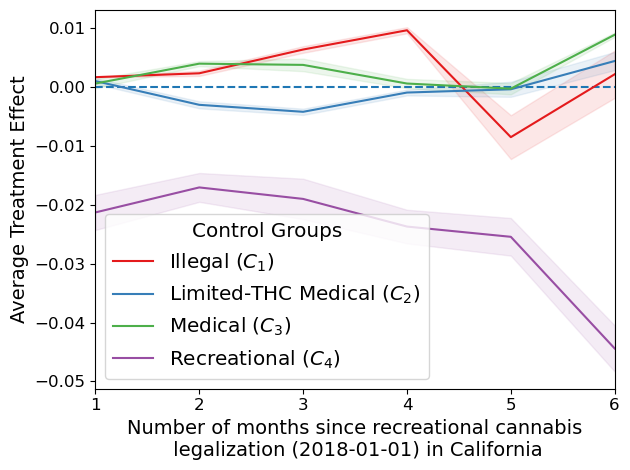

  0%|          | 0/2 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 2/2 [00:14<00:00,  7.04s/it]


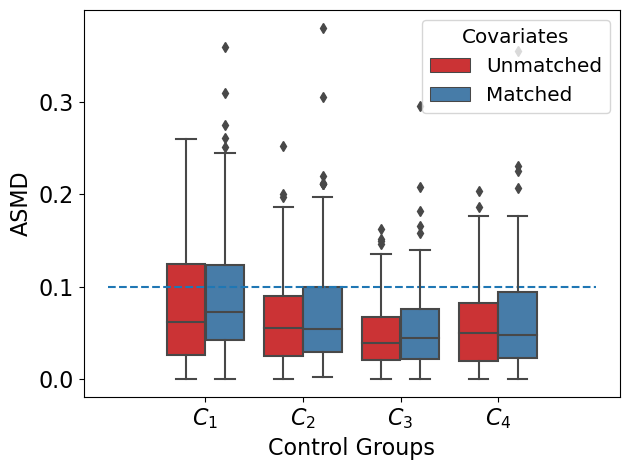

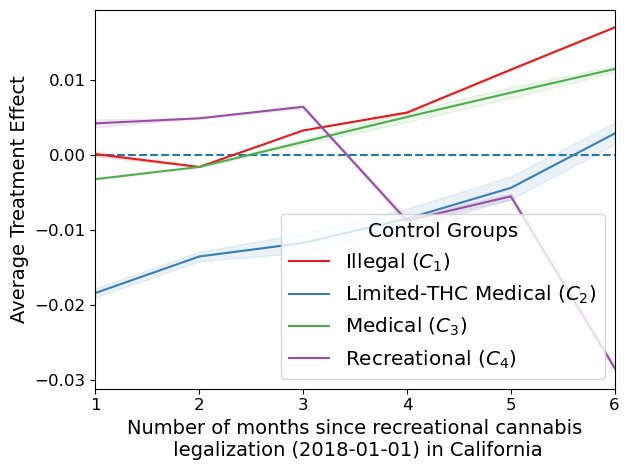

In [214]:
treatment_state = 'California'
effectsDf, accessDf, combinedDf = run_iptw_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='LR',
                                                      num_bootstrap=2,
                                                      ex_suffix=experiment_suffix
                                                     )
effectsDf, accessDf, combinedDf = run_iptw_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='GBM',
                                                      num_bootstrap=2,
                                                      ex_suffix=experiment_suffix
                                                     )
effectsDf, accessDf, combinedDf = run_ps_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='LR',
                                                      num_bootstrap=2,
                                                      ex_suffix=experiment_suffix
                                                     )
effectsDf, accessDf, combinedDf = run_ps_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='GBM',
                                                      num_bootstrap=2,
                                                      ex_suffix=experiment_suffix
                                                     )
effectsDf, accessDf, combinedDf = run_fb_experiment(treatment_state, base_df, juul_df, weed_df,
                                                    metric='cosine',
                                                    num_bootstrap=2,
                                                      ex_suffix=experiment_suffix
                                                     )

In [250]:
experiment_suffix='_rt_vis'
bdfIP_LR = pd.read_csv(f'California_LR_iptw{experiment_suffix}_2_balance_df.csv')
bdfIP_GBM = pd.read_csv(f'California_GBM_iptw{experiment_suffix}_2_balance_df.csv')
bdfPS_LR = pd.read_csv(f'California_LR_ps{experiment_suffix}_2_balance_df.csv')
bdfPS_GBM = pd.read_csv(f'California_GBM_ps{experiment_suffix}_2_balance_df.csv')
bdfFB = pd.read_csv(f'California_cosine_fb{experiment_suffix}_2_balance_df.csv')

def cleanup(df, exclude_raw=True, raw_index=None):
    df = df[df['bootstrap']==0]
    if exclude_raw:
        df = df[df['raw']==0]
        df['raw'] = raw_index
    return df

bdf1 = cleanup(bdfIP_LR, exclude_raw=False)
bdfList = [bdf1]
for i,bdf in enumerate([bdfIP_GBM, bdfPS_LR, bdfPS_GBM, bdfFB], 2):
    bdf = cleanup(bdf, raw_index=i)
    bdfList.append(bdf)
allBdf = pd.concat(bdfList)


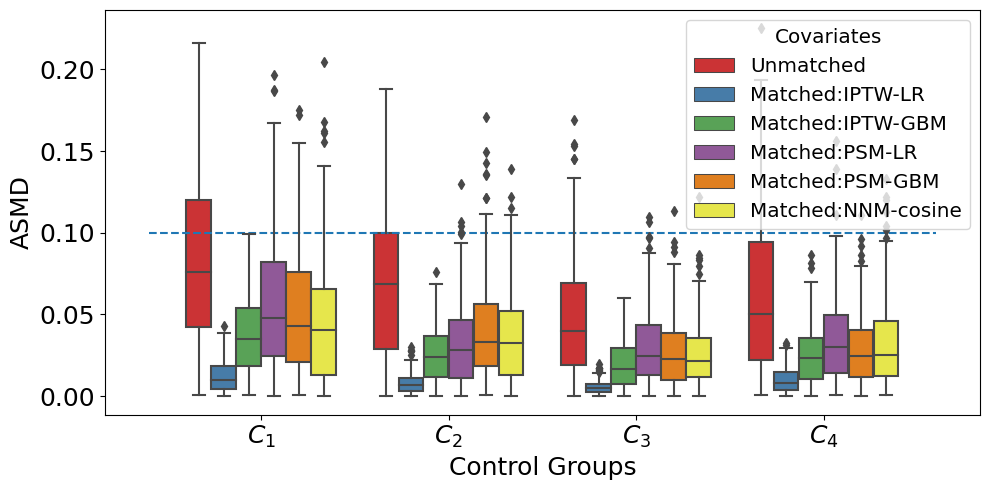

In [252]:
# Define some hatches
hatches = cycle(['+++', '///', 'xx', "---", '**', 'oo'])

def plot_combined_covariate_balance(accessDf, fontsize=18, labelsize=18):
    accessDf = accessDf[accessDf['bootstrap']==0]
#     plt.subplot(111)
    plt.figure(figsize=(10,5))
    ax = sns.boxplot(x='control', y='smd', data=accessDf, palette='Set1', hue='raw', hue_order=[1,0,2,3,4,5])#, split=True)
    ax.hlines(0.1,-0.6,3.6, linestyles='--')
    plt.xlabel("Control Groups", fontsize=fontsize)
    plt.ylabel("ASMD", fontsize=fontsize)
    plt.xticks(ticks=[0,1,2,3], labels=['$C_1$', '$C_2$', '$C_3$', '$C_4$'])
    legend = ax.legend(title='Covariates', fontsize='x-large', title_fontsize='x-large', loc='upper right')
    ax.tick_params(axis = 'both', which = 'major', labelsize = labelsize)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = labelsize)
#     for i, patch in enumerate(ax.artists):
#     # Boxes from left to right
#         hatch = next(hatches)
#         patch.set_hatch(hatch)
    legend.texts[0].set_text('Unmatched')
    legend.texts[1].set_text('Matched:IPTW-LR')
    legend.texts[2].set_text('Matched:IPTW-GBM')
    legend.texts[3].set_text('Matched:PSM-LR')
    legend.texts[4].set_text('Matched:PSM-GBM')
    legend.texts[5].set_text('Matched:NNM-cosine')
    plt.tight_layout()
    # plt.show()
plot_combined_covariate_balance(allBdf)
plt.savefig(f'sensitivity_analysis_balance_combined_California.pdf')

  0%|          | 0/2 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 2/2 [00:15<00:00,  7.74s/it]


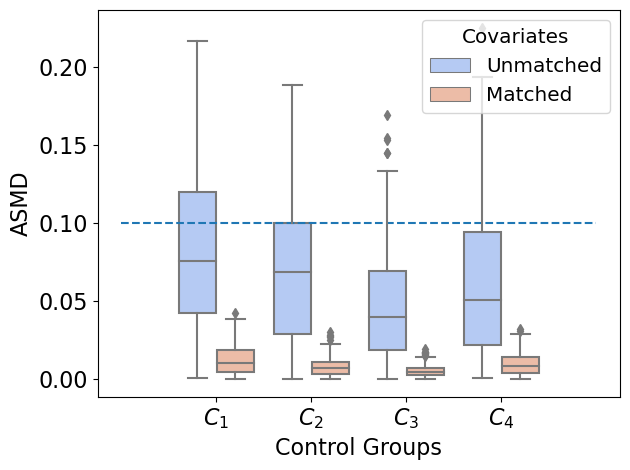

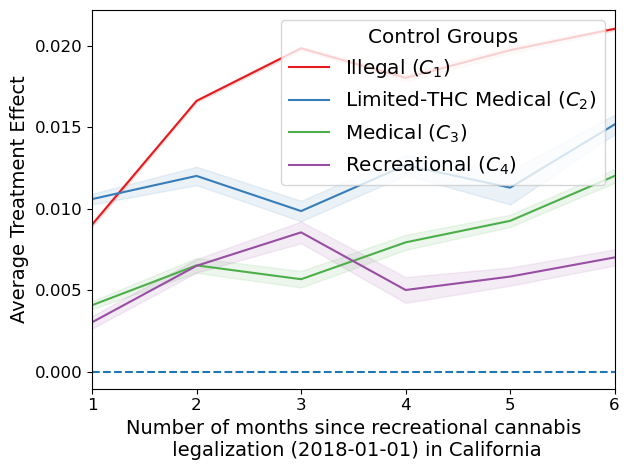

In [173]:
treatment_state = 'California'
effectsDf, accessDf, combinedDf = run_iptw_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='LR',
                                                      num_bootstrap=2,
                                                      ex_suffix=experiment_suffix
                                                     )


  0%|          | 0/2 [00:00<?, ?it/s]

Massachusetts 2017-07-28


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


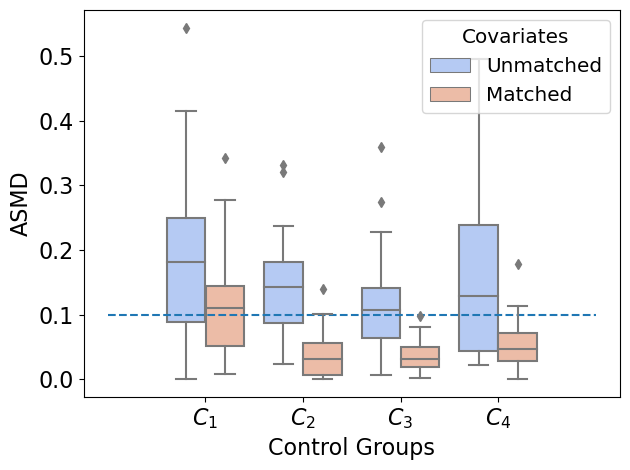

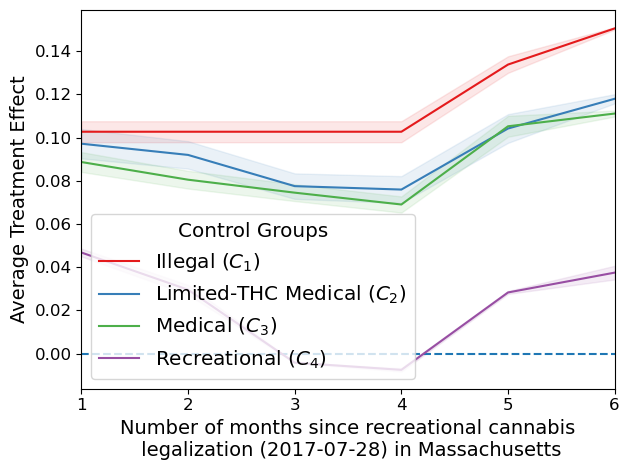

In [174]:
treatment_state = 'Massachusetts'
effectsDf, accessDf, combinedDf = run_iptw_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='LR',
                                                      num_bootstrap=2,
                                                      ex_suffix=experiment_suffix
                                                     )


  0%|          | 0/2 [00:00<?, ?it/s]

Vermont 2018-07-01


100%|██████████| 2/2 [00:22<00:00, 11.13s/it]


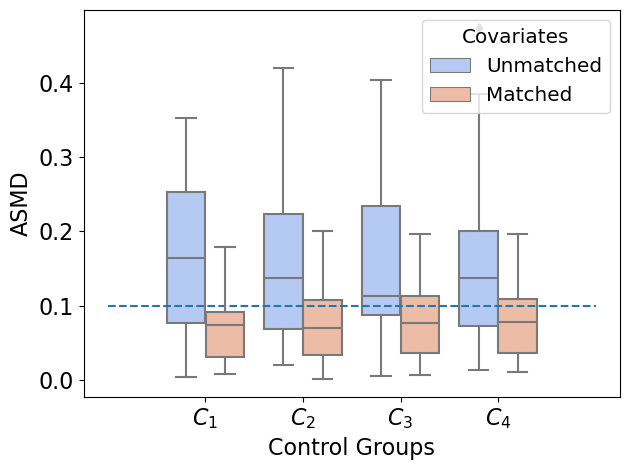

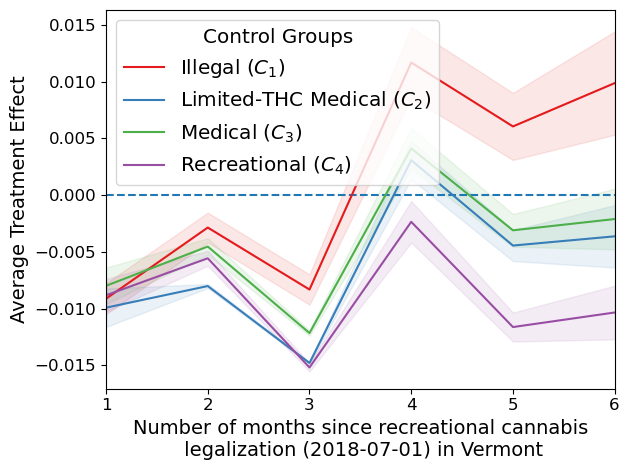

In [175]:
treatment_state = 'Vermont'
effectsDf, accessDf, combinedDf = run_iptw_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='LR',
                                                      num_bootstrap=2,
                                                      ex_suffix=experiment_suffix
                                                     )


  0%|          | 0/200 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 200/200 [37:27<00:00, 11.24s/it]


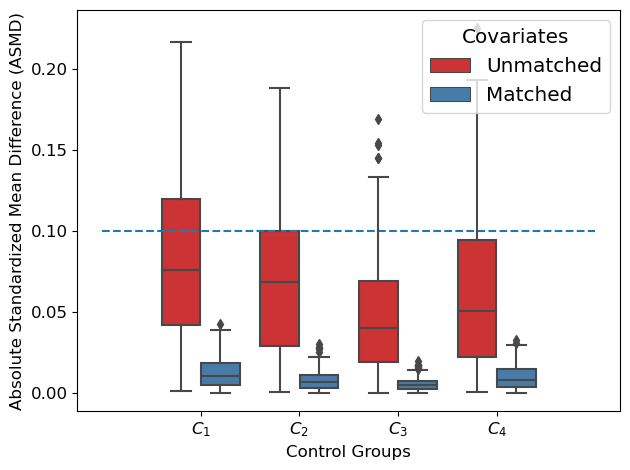

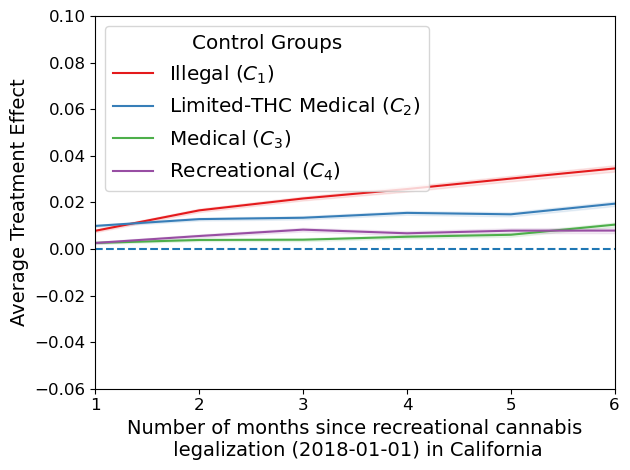

In [223]:
treatment_state = 'California'
CeffectsDf, CaccessDf, CcombinedDf = run_iptw_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='LR',
                                                      num_bootstrap=200,
                                                      ex_suffix=experiment_suffix
                                                     )


  0%|          | 0/200 [00:00<?, ?it/s]

Vermont 2018-07-01


100%|██████████| 200/200 [57:11<00:00, 17.16s/it]


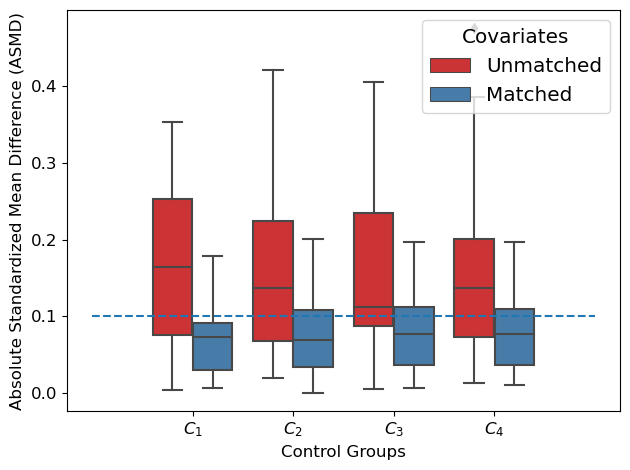

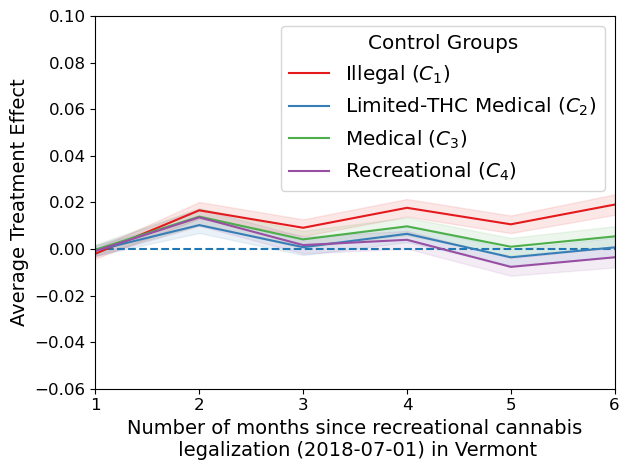

In [224]:
treatment_state = 'Vermont'
VeffectsDf, VaccessDf, VcombinedDf = run_iptw_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='LR',
                                                      num_bootstrap=200,
                                                      ex_suffix=experiment_suffix
                                                     )

  0%|          | 0/200 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 200/200 [36:10<00:00, 10.85s/it]


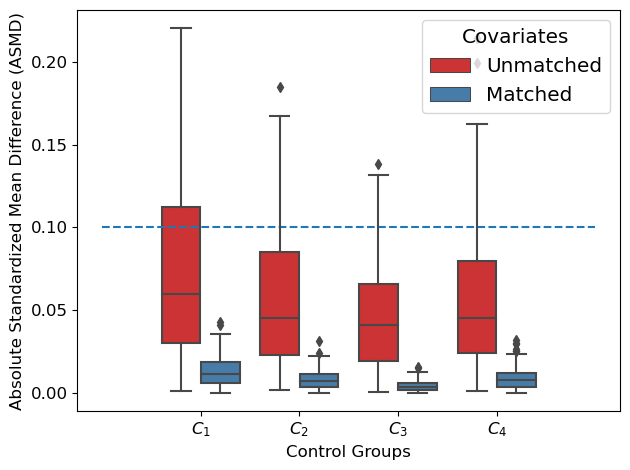

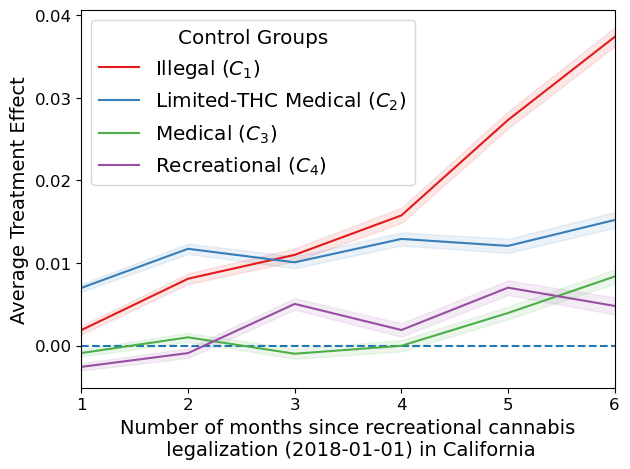

In [72]:
effectsDf, accessDf, combinedDf = run_iptw_experiment(treatment_state, base_df, juul_df, weed_df,
                                                      model='LR',
                                                      num_bootstrap=1,
                                                      ex_suffix=experiment_suffix
                                                     )

In [253]:
def get_pop_stats(treatment_state, combinedDf):
    countT = combinedDf[(combinedDf['estimation']=='ATE')&(combinedDf['label']==1)].drop_duplicates(subset=['bootstrap'])
    countC = combinedDf[(combinedDf['estimation']=='ATE')&(combinedDf['label']==0)].drop_duplicates(subset=['bootstrap', 'control'])
    print_info(treatment_state)
    print(countT['count'].agg(['mean', 'std']))
    print(countC.groupby('control')['count'].agg(['mean', 'std']))
get_pop_stats('California', VcombinedDf)

California 2018-01-01
mean    49.645000
std      3.894201
Name: count, dtype: float64
              mean         std
control                       
1         1476.575   25.946493
2         7729.515   60.672196
3        13709.665  115.182192
4         6248.865   71.184005


  0%|          | 0/200 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 200/200 [1:01:48<00:00, 18.54s/it]


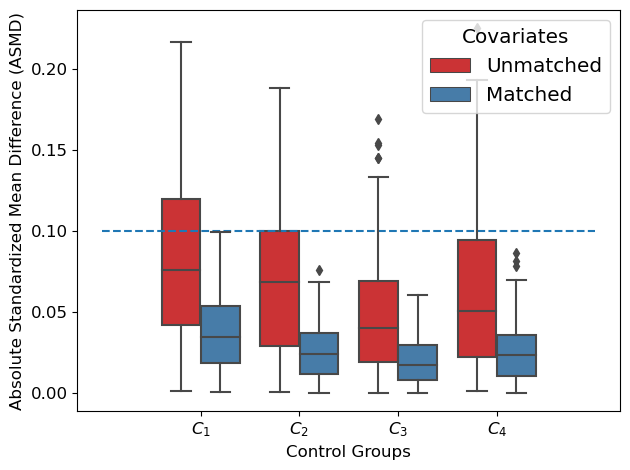

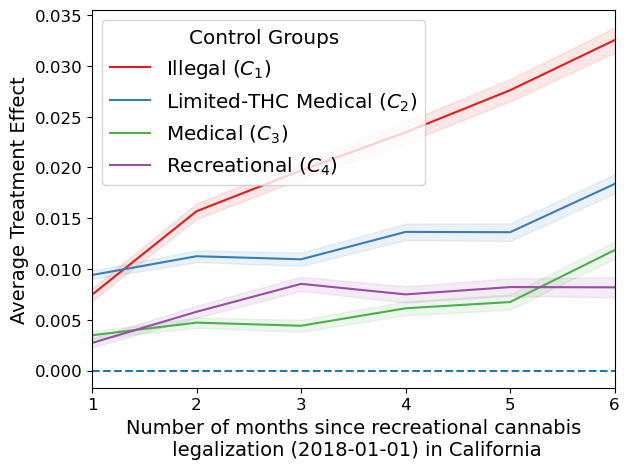

In [228]:
treatment_state = 'California'
effectsDf, accessDf, combinedDf = run_iptw_experiment('California', base_df, juul_df, weed_df,
                                                      model='GBM',
                                                      num_bootstrap=200,
                                                      ex_suffix=experiment_suffix
                                                     )

  0%|          | 0/200 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 200/200 [1:12:23<00:00, 21.72s/it]


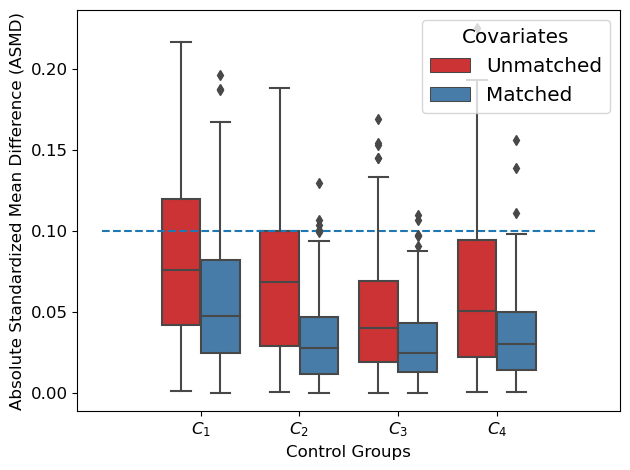

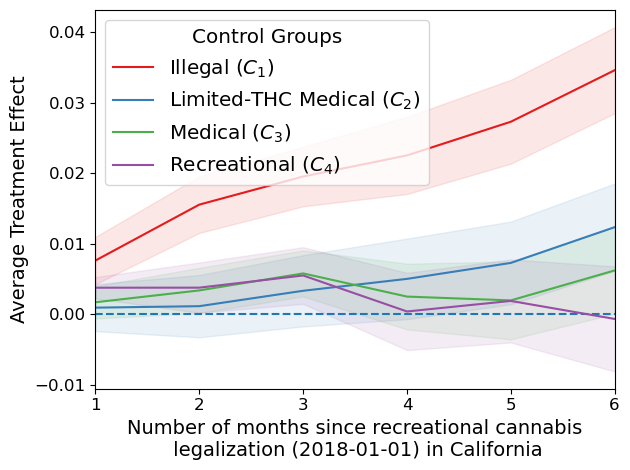

In [229]:
treatment_state = 'California'
effectsDf, accessDf, combinedDf = run_ps_experiment('California', base_df, juul_df, weed_df,
                                                      model='LR',
                                                      num_bootstrap=200,
                                                      ex_suffix=experiment_suffix
                                                     )

  0%|          | 0/200 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 200/200 [1:31:53<00:00, 27.57s/it]


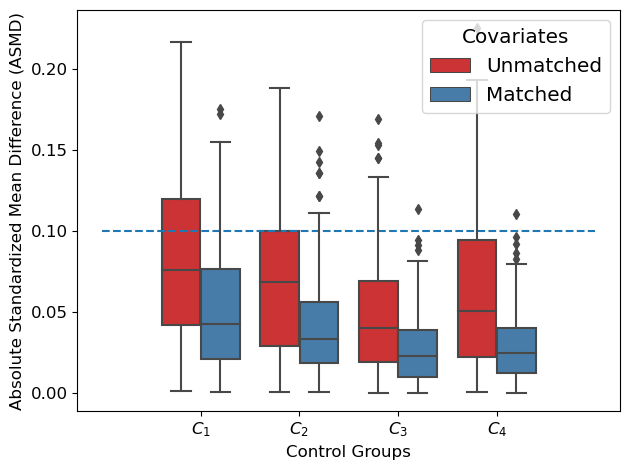

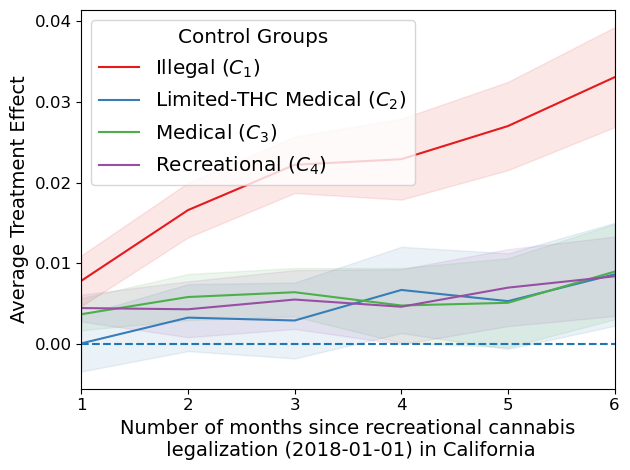

In [230]:
treatment_state = 'California'
effectsDf, accessDf, combinedDf = run_ps_experiment('California', base_df, juul_df, weed_df,
                                                      model='GBM',
                                                      num_bootstrap=200,
                                                      ex_suffix=experiment_suffix
                                                     )

  0%|          | 0/200 [00:00<?, ?it/s]

California 2018-01-01


100%|██████████| 200/200 [1:26:19<00:00, 25.90s/it]


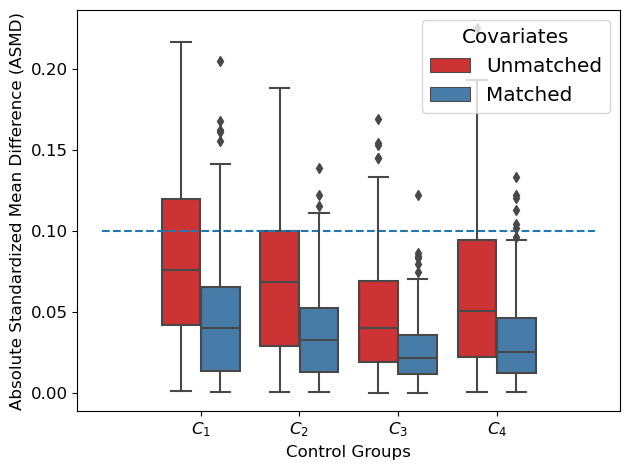

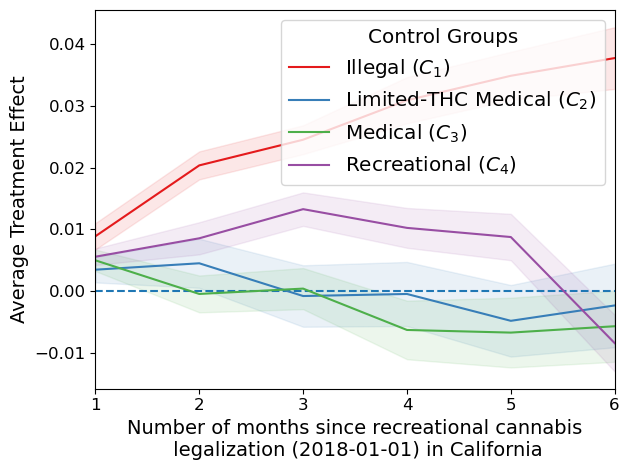

In [234]:
treatment_state = 'California'
FBeffectsDf, FBaccessDf, FBcombinedDf = run_fb_experiment('California', base_df, juul_df, weed_df,
                                                    metric='cosine',
                                                    num_bootstrap=200,
                                                      ex_suffix=experiment_suffix
                                                     )

In [58]:
# effectsDf, accessDf, combinedDf = run_fb_experiment(treatment_state,
#                                                     popStateFeatures,
#                                                     featureNames,
#                                                     metric='correlation',
#                                                     num_bootstrap=1
#                                                      )